In [2]:
import numpy as np

class Node:
    def _init_(self, inputs=[]):
        self.inputs = inputs
        self.output = []
        
        for n in self.inputs:
            n.outputs.append(self)
            
            
        self.value = Node
        
        self.gradients = {}
        
        
        
    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''
        
        raise NotImplemented
        
    def backward(self):
        
        raise NotImplemented
        
        
class Input(Node):
    def _init_(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        
        Node._init_(self)
        
    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value =value
            
            
    def backward(self):
        self.gradients = {self:0}
        for  n in self.outputs:
            grad_cost = n.gtadients[self]
            self.gradients[self] = grad_cost * 1
            
        
class Add(Node):
    def _init_(self, *nodes):
        Node._init_(self, nodes)
        
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        
        
        
        
        
class Linear(Node):
    def _init_(self, nodes, weights, bias):
        Node._init_(self, [nodes, weights, bias])
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

       
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
            
class Sigmoid(Node):
    def _init_(self, node):
        Node._init_(self, [node])
        
        
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    
    def forward(self):
        self.x = self.inputs[0].value   
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self] 

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            
            
class MSE(Node):
    def _init_(self, y, a):
        Node._init_(self, [y, a])
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)
        
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

        
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()
        
    for n in  graph[::-1]:
        n.backward()
    
    
def topological_sort(feed_dict):
    """
    ort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
           

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L
            
    
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [3]:
from sklearn.datasets import load_boston

In [4]:
data = load_boston()

In [5]:
losses = []

In [6]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""



import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample



data = load_boston()
X_ = data['data']
y_ = data['target']


X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)


X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000

m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))


for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
    
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

       
        X.value = X_batch
        y.value = y_batch

     
        _ = None
        forward_and_backward(_, graph) # set output node not important.

      
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)



TypeError: Linear() takes no arguments

In [7]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [8]:
forward(l2,graph)

NameError: name 'l2' is not defined

In [9]:
import matplotlib.pyplot as plt

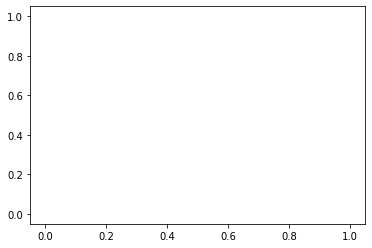

In [10]:
plt.plot(range(len(losses)), losses)

In [11]:
W2.value 

AttributeError: 'Input' object has no attribute 'value'

In [12]:
X_ = data['data']

In [13]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [14]:
import keras

Using TensorFlow backend.


In [15]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [16]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [17]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 112us/step - loss: 138.9909 - mse: 138.9909
Epoch 2/5000
506/506 [==============================] - 0s 24us/step - loss: 81.7943 - mse: 81.7943
Epoch 3/5000
506/506 [==============================] - 0s 26us/step - loss: 81.6779 - mse: 81.6779
Epoch 4/5000
506/506 [==============================] - 0s 24us/step - loss: 79.3081 - mse: 79.3081
Epoch 5/5000
506/506 [==============================] - 0s 22us/step - loss: 81.1353 - mse: 81.1353
Epoch 6/5000
506/506 [==============================] - 0s 26us/step - loss: 81.3561 - mse: 81.3561
Epoch 7/5000
506/506 [==============================] - 0s 34us/step - loss: 77.0057 - mse: 77.0057
Epoch 8/5000
506/506 [==============================] - 0s 49us/step - loss: 74.6366 - mse: 74.6366
Epoch 9/5000
506/506 [==============================] - 0s 24us/step - loss: 76.4777 - mse: 76.4777
Epoch 10/5000
506/506 [==============================] - 0s 30us/step - loss: 92.0598 - mse: 92.0

506/506 [==============================] - 0s 37us/step - loss: 85.3606 - mse: 85.3606
Epoch 83/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7393 - mse: 84.7393
Epoch 84/5000
506/506 [==============================] - 0s 35us/step - loss: 85.8783 - mse: 85.8783
Epoch 85/5000
506/506 [==============================] - 0s 35us/step - loss: 85.5671 - mse: 85.5671
Epoch 86/5000
506/506 [==============================] - 0s 41us/step - loss: 85.8740 - mse: 85.8740
Epoch 87/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1840 - mse: 85.1840
Epoch 88/5000
506/506 [==============================] - 0s 49us/step - loss: 85.5860 - mse: 85.5860
Epoch 89/5000
506/506 [==============================] - 0s 37us/step - loss: 85.4934 - mse: 85.4934
Epoch 90/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6934 - mse: 84.6934
Epoch 91/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2974 - mse: 85.2974
Epoc

506/506 [==============================] - 0s 45us/step - loss: 85.1683 - mse: 85.1683
Epoch 163/5000
506/506 [==============================] - 0s 65us/step - loss: 85.8051 - mse: 85.8051
Epoch 164/5000
506/506 [==============================] - 0s 61us/step - loss: 85.9568 - mse: 85.9568
Epoch 165/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0632 - mse: 85.0632
Epoch 166/5000
506/506 [==============================] - 0s 83us/step - loss: 85.6582 - mse: 85.6582
Epoch 167/5000
506/506 [==============================] - 0s 73us/step - loss: 85.0251 - mse: 85.0251
Epoch 168/5000
506/506 [==============================] - 0s 77us/step - loss: 85.2125 - mse: 85.2125
Epoch 169/5000
506/506 [==============================] - 0s 102us/step - loss: 85.7291 - mse: 85.7291
Epoch 170/5000
506/506 [==============================] - 0s 71us/step - loss: 84.8539 - mse: 84.8539
Epoch 171/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1415 - mse: 85

506/506 [==============================] - 0s 87us/step - loss: 85.0052 - mse: 85.0052
Epoch 243/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1769 - mse: 85.1769
Epoch 244/5000
506/506 [==============================] - 0s 61us/step - loss: 85.7215 - mse: 85.7215
Epoch 245/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9877 - mse: 84.9877
Epoch 246/5000
506/506 [==============================] - 0s 55us/step - loss: 85.1799 - mse: 85.1799
Epoch 247/5000
506/506 [==============================] - 0s 75us/step - loss: 85.5570 - mse: 85.5570
Epoch 248/5000
506/506 [==============================] - 0s 61us/step - loss: 85.2156 - mse: 85.2156
Epoch 249/5000
506/506 [==============================] - 0s 73us/step - loss: 85.6332 - mse: 85.6332
Epoch 250/5000
506/506 [==============================] - 0s 65us/step - loss: 85.3852 - mse: 85.3852
Epoch 251/5000
506/506 [==============================] - 0s 77us/step - loss: 84.8235 - mse: 84.

506/506 [==============================] - 0s 55us/step - loss: 85.4844 - mse: 85.4844
Epoch 323/5000
506/506 [==============================] - 0s 79us/step - loss: 85.6466 - mse: 85.6466
Epoch 324/5000
506/506 [==============================] - 0s 95us/step - loss: 85.1890 - mse: 85.1890
Epoch 325/5000
506/506 [==============================] - 0s 104us/step - loss: 85.1477 - mse: 85.1477
Epoch 326/5000
506/506 [==============================] - 0s 77us/step - loss: 85.1352 - mse: 85.1352
Epoch 327/5000
506/506 [==============================] - 0s 95us/step - loss: 84.8977 - mse: 84.8977
Epoch 328/5000
506/506 [==============================] - 0s 89us/step - loss: 86.2101 - mse: 86.2101
Epoch 329/5000
506/506 [==============================] - 0s 73us/step - loss: 84.5261 - mse: 84.5261
Epoch 330/5000
506/506 [==============================] - 0s 73us/step - loss: 84.9245 - mse: 84.9245
Epoch 331/5000
506/506 [==============================] - 0s 85us/step - loss: 84.5956 - mse: 84

506/506 [==============================] - 0s 71us/step - loss: 85.2439 - mse: 85.2439
Epoch 403/5000
506/506 [==============================] - 0s 83us/step - loss: 85.1803 - mse: 85.1803
Epoch 404/5000
506/506 [==============================] - 0s 53us/step - loss: 84.7217 - mse: 84.7217
Epoch 405/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8768 - mse: 84.8768
Epoch 406/5000
506/506 [==============================] - 0s 79us/step - loss: 85.2033 - mse: 85.2033
Epoch 407/5000
506/506 [==============================] - 0s 75us/step - loss: 84.8524 - mse: 84.8524
Epoch 408/5000
506/506 [==============================] - 0s 87us/step - loss: 84.7795 - mse: 84.7795
Epoch 409/5000
506/506 [==============================] - 0s 207us/step - loss: 85.4530 - mse: 85.4530
Epoch 410/5000
506/506 [==============================] - 0s 43us/step - loss: 84.5722 - mse: 84.5722
Epoch 411/5000
506/506 [==============================] - 0s 132us/step - loss: 84.5522 - mse: 8

506/506 [==============================] - 0s 67us/step - loss: 84.8985 - mse: 84.8985
Epoch 483/5000
506/506 [==============================] - 0s 73us/step - loss: 85.1317 - mse: 85.1317
Epoch 484/5000
506/506 [==============================] - 0s 150us/step - loss: 85.3729 - mse: 85.3729
Epoch 485/5000
506/506 [==============================] - 0s 65us/step - loss: 84.6129 - mse: 84.6129
Epoch 486/5000
506/506 [==============================] - 0s 104us/step - loss: 84.7976 - mse: 84.7976
Epoch 487/5000
506/506 [==============================] - 0s 67us/step - loss: 85.0009 - mse: 85.0009
Epoch 488/5000
506/506 [==============================] - 0s 95us/step - loss: 85.1554 - mse: 85.1553
Epoch 489/5000
506/506 [==============================] - 0s 81us/step - loss: 85.1972 - mse: 85.1972
Epoch 490/5000
506/506 [==============================] - 0s 81us/step - loss: 85.2170 - mse: 85.2170
Epoch 491/5000
506/506 [==============================] - 0s 59us/step - loss: 84.7487 - mse: 8

506/506 [==============================] - 0s 26us/step - loss: 85.1754 - mse: 85.1754
Epoch 563/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1389 - mse: 85.1389
Epoch 564/5000
506/506 [==============================] - 0s 32us/step - loss: 85.4601 - mse: 85.4601
Epoch 565/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0160 - mse: 85.0160
Epoch 566/5000
506/506 [==============================] - 0s 34us/step - loss: 85.2936 - mse: 85.2936
Epoch 567/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2074 - mse: 85.2074
Epoch 568/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8105 - mse: 84.8105
Epoch 569/5000
506/506 [==============================] - 0s 61us/step - loss: 85.3193 - mse: 85.3193
Epoch 570/5000
506/506 [==============================] - 0s 65us/step - loss: 85.3576 - mse: 85.3576
Epoch 571/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1688 - mse: 85.

506/506 [==============================] - 0s 75us/step - loss: 85.0452 - mse: 85.0452
Epoch 643/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0335 - mse: 85.0335
Epoch 644/5000
506/506 [==============================] - 0s 47us/step - loss: 85.4533 - mse: 85.4533
Epoch 645/5000
506/506 [==============================] - 0s 41us/step - loss: 85.4432 - mse: 85.4432
Epoch 646/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0595 - mse: 85.0595
Epoch 647/5000
506/506 [==============================] - 0s 63us/step - loss: 85.7146 - mse: 85.7146
Epoch 648/5000
506/506 [==============================] - 0s 53us/step - loss: 84.5518 - mse: 84.5518
Epoch 649/5000
506/506 [==============================] - 0s 65us/step - loss: 85.1198 - mse: 85.1198
Epoch 650/5000
506/506 [==============================] - 0s 47us/step - loss: 84.6890 - mse: 84.6890
Epoch 651/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9046 - mse: 84.

506/506 [==============================] - 0s 43us/step - loss: 84.2367 - mse: 84.2367
Epoch 723/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9083 - mse: 84.9083
Epoch 724/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7376 - mse: 84.7376
Epoch 725/5000
506/506 [==============================] - 0s 65us/step - loss: 84.8589 - mse: 84.8589
Epoch 726/5000
506/506 [==============================] - 0s 37us/step - loss: 85.6766 - mse: 85.6766
Epoch 727/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7917 - mse: 84.7917
Epoch 728/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3450 - mse: 85.3450
Epoch 729/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0875 - mse: 85.0875
Epoch 730/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3121 - mse: 85.3121
Epoch 731/5000
506/506 [==============================] - 0s 57us/step - loss: 84.5387 - mse: 84.

506/506 [==============================] - 0s 24us/step - loss: 85.2517 - mse: 85.2517
Epoch 803/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5804 - mse: 84.5804
Epoch 804/5000
506/506 [==============================] - 0s 37us/step - loss: 85.6864 - mse: 85.6864
Epoch 805/5000
506/506 [==============================] - 0s 45us/step - loss: 85.3368 - mse: 85.3368
Epoch 806/5000
506/506 [==============================] - 0s 61us/step - loss: 85.1363 - mse: 85.1363
Epoch 807/5000
506/506 [==============================] - 0s 39us/step - loss: 85.4202 - mse: 85.4202
Epoch 808/5000
506/506 [==============================] - 0s 34us/step - loss: 85.2386 - mse: 85.2386
Epoch 809/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1045 - mse: 85.1045
Epoch 810/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2701 - mse: 85.2701
Epoch 811/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8440 - mse: 84.

Epoch 882/5000
506/506 [==============================] - 0s 77us/step - loss: 85.0526 - mse: 85.0526
Epoch 883/5000
506/506 [==============================] - 0s 81us/step - loss: 85.6144 - mse: 85.6144
Epoch 884/5000
506/506 [==============================] - 0s 87us/step - loss: 84.6023 - mse: 84.6023
Epoch 885/5000
506/506 [==============================] - 0s 63us/step - loss: 85.0650 - mse: 85.0650
Epoch 886/5000
506/506 [==============================] - 0s 73us/step - loss: 84.7713 - mse: 84.7713
Epoch 887/5000
506/506 [==============================] - 0s 47us/step - loss: 85.6123 - mse: 85.6123
Epoch 888/5000
506/506 [==============================] - 0s 93us/step - loss: 85.4264 - mse: 85.4264
Epoch 889/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0277 - mse: 85.0277
Epoch 890/5000
506/506 [==============================] - 0s 81us/step - loss: 84.9015 - mse: 84.9016
Epoch 891/5000
506/506 [==============================] - 0s 83us/step - loss: 84.

506/506 [==============================] - 0s 69us/step - loss: 85.2501 - mse: 85.2501
Epoch 962/5000
506/506 [==============================] - 0s 81us/step - loss: 85.0278 - mse: 85.0278
Epoch 963/5000
506/506 [==============================] - 0s 57us/step - loss: 85.8395 - mse: 85.8395
Epoch 964/5000
506/506 [==============================] - 0s 93us/step - loss: 85.6702 - mse: 85.6702
Epoch 965/5000
506/506 [==============================] - 0s 97us/step - loss: 84.5962 - mse: 84.5962
Epoch 966/5000
506/506 [==============================] - 0s 73us/step - loss: 85.0975 - mse: 85.0975
Epoch 967/5000
506/506 [==============================] - 0s 112us/step - loss: 85.5870 - mse: 85.5871
Epoch 968/5000
506/506 [==============================] - 0s 61us/step - loss: 85.0884 - mse: 85.0884
Epoch 969/5000
506/506 [==============================] - 0s 83us/step - loss: 84.6729 - mse: 84.6729
Epoch 970/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8405 - mse: 84

506/506 [==============================] - 0s 75us/step - loss: 84.2292 - mse: 84.2292
Epoch 1041/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9522 - mse: 84.9522
Epoch 1042/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8707 - mse: 84.8707
Epoch 1043/5000
506/506 [==============================] - 0s 79us/step - loss: 85.1562 - mse: 85.1562
Epoch 1044/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0512 - mse: 85.0512
Epoch 1045/5000
506/506 [==============================] - 0s 73us/step - loss: 85.1439 - mse: 85.1439
Epoch 1046/5000
506/506 [==============================] - 0s 77us/step - loss: 84.7390 - mse: 84.7390
Epoch 1047/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8655 - mse: 84.8655
Epoch 1048/5000
506/506 [==============================] - 0s 116us/step - loss: 84.8630 - mse: 84.8630
Epoch 1049/5000
506/506 [==============================] - 0s 81us/step - loss: 84.5385 

506/506 [==============================] - 0s 89us/step - loss: 84.7392 - mse: 84.7392
Epoch 1120/5000
506/506 [==============================] - 0s 55us/step - loss: 85.6744 - mse: 85.6744
Epoch 1121/5000
506/506 [==============================] - 0s 93us/step - loss: 84.6034 - mse: 84.6034
Epoch 1122/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9798 - mse: 84.9798
Epoch 1123/5000
506/506 [==============================] - 0s 65us/step - loss: 85.0686 - mse: 85.0686
Epoch 1124/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3153 - mse: 85.3153
Epoch 1125/5000
506/506 [==============================] - 0s 45us/step - loss: 84.6540 - mse: 84.6540
Epoch 1126/5000
506/506 [==============================] - 0s 43us/step - loss: 84.9588 - mse: 84.9588
Epoch 1127/5000
506/506 [==============================] - 0s 67us/step - loss: 85.2106 - mse: 85.2106
Epoch 1128/5000
506/506 [==============================] - 0s 71us/step - loss: 84.6437 -

506/506 [==============================] - 0s 37us/step - loss: 84.4426 - mse: 84.4426
Epoch 1199/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0531 - mse: 85.0531
Epoch 1200/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0427 - mse: 85.0427
Epoch 1201/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9335 - mse: 84.9335
Epoch 1202/5000
506/506 [==============================] - 0s 85us/step - loss: 84.6486 - mse: 84.6486
Epoch 1203/5000
506/506 [==============================] - 0s 65us/step - loss: 85.3417 - mse: 85.3417
Epoch 1204/5000
506/506 [==============================] - 0s 49us/step - loss: 84.5418 - mse: 84.5418
Epoch 1205/5000
506/506 [==============================] - 0s 93us/step - loss: 84.8431 - mse: 84.8431
Epoch 1206/5000
506/506 [==============================] - 0s 106us/step - loss: 85.2653 - mse: 85.2653
Epoch 1207/5000
506/506 [==============================] - 0s 99us/step - loss: 85.3996 

506/506 [==============================] - 0s 37us/step - loss: 85.0091 - mse: 85.0091
Epoch 1278/5000
506/506 [==============================] - 0s 43us/step - loss: 84.9564 - mse: 84.9564
Epoch 1279/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7444 - mse: 84.7444
Epoch 1280/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3392 - mse: 85.3392
Epoch 1281/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0016 - mse: 85.0016
Epoch 1282/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5964 - mse: 84.5964
Epoch 1283/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7662 - mse: 84.7662
Epoch 1284/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0303 - mse: 85.0303
Epoch 1285/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0256 - mse: 85.0256
Epoch 1286/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8274 -

506/506 [==============================] - 0s 37us/step - loss: 85.3710 - mse: 85.3710
Epoch 1357/5000
506/506 [==============================] - 0s 37us/step - loss: 85.1661 - mse: 85.1661
Epoch 1358/5000
506/506 [==============================] - 0s 24us/step - loss: 85.4996 - mse: 85.4996
Epoch 1359/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9348 - mse: 84.9348
Epoch 1360/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1643 - mse: 85.1642
Epoch 1361/5000
506/506 [==============================] - 0s 49us/step - loss: 85.4145 - mse: 85.4145
Epoch 1362/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8950 - mse: 84.8950
Epoch 1363/5000
506/506 [==============================] - 0s 47us/step - loss: 84.6948 - mse: 84.6948
Epoch 1364/5000
506/506 [==============================] - 0s 35us/step - loss: 84.5972 - mse: 84.5972
Epoch 1365/5000
506/506 [==============================] - 0s 37us/step - loss: 85.3140 -

506/506 [==============================] - 0s 45us/step - loss: 84.7470 - mse: 84.7470
Epoch 1436/5000
506/506 [==============================] - 0s 47us/step - loss: 85.4326 - mse: 85.4326
Epoch 1437/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8164 - mse: 84.8164
Epoch 1438/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0423 - mse: 85.0423
Epoch 1439/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6374 - mse: 84.6374
Epoch 1440/5000
506/506 [==============================] - 0s 57us/step - loss: 85.0942 - mse: 85.0942
Epoch 1441/5000
506/506 [==============================] - 0s 39us/step - loss: 85.6511 - mse: 85.6511
Epoch 1442/5000
506/506 [==============================] - 0s 55us/step - loss: 85.2944 - mse: 85.2944
Epoch 1443/5000
506/506 [==============================] - 0s 24us/step - loss: 84.8118 - mse: 84.8118
Epoch 1444/5000
506/506 [==============================] - 0s 43us/step - loss: 84.3976 -

506/506 [==============================] - 0s 51us/step - loss: 85.0235 - mse: 85.0235
Epoch 1515/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9494 - mse: 84.9494
Epoch 1516/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5325 - mse: 85.5325
Epoch 1517/5000
506/506 [==============================] - 0s 75us/step - loss: 85.4359 - mse: 85.4359
Epoch 1518/5000
506/506 [==============================] - ETA: 0s - loss: 86.9363 - mse: 86.936 - 0s 51us/step - loss: 85.3757 - mse: 85.3757
Epoch 1519/5000
506/506 [==============================] - 0s 63us/step - loss: 84.9006 - mse: 84.9006
Epoch 1520/5000
506/506 [==============================] - 0s 79us/step - loss: 84.7799 - mse: 84.7799
Epoch 1521/5000
506/506 [==============================] - 0s 97us/step - loss: 85.1418 - mse: 85.1419
Epoch 1522/5000
506/506 [==============================] - 0s 101us/step - loss: 85.5909 - mse: 85.5909
Epoch 1523/5000
506/506 [=======================

506/506 [==============================] - 0s 35us/step - loss: 85.3866 - mse: 85.3866
Epoch 1594/5000
506/506 [==============================] - 0s 35us/step - loss: 85.3203 - mse: 85.3203
Epoch 1595/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2840 - mse: 85.2840
Epoch 1596/5000
506/506 [==============================] - 0s 45us/step - loss: 85.5596 - mse: 85.5596
Epoch 1597/5000
506/506 [==============================] - 0s 37us/step - loss: 84.8479 - mse: 84.8479
Epoch 1598/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8922 - mse: 84.8922
Epoch 1599/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1745 - mse: 85.1745
Epoch 1600/5000
506/506 [==============================] - 0s 43us/step - loss: 84.9026 - mse: 84.9026
Epoch 1601/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1925 - mse: 85.1925
Epoch 1602/5000
506/506 [==============================] - 0s 59us/step - loss: 84.7497 -

506/506 [==============================] - 0s 39us/step - loss: 85.2293 - mse: 85.2293
Epoch 1673/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5298 - mse: 84.5298
Epoch 1674/5000
506/506 [==============================] - 0s 41us/step - loss: 85.2072 - mse: 85.2072
Epoch 1675/5000
506/506 [==============================] - 0s 53us/step - loss: 84.7383 - mse: 84.7383
Epoch 1676/5000
506/506 [==============================] - 0s 30us/step - loss: 86.1168 - mse: 86.1168
Epoch 1677/5000
506/506 [==============================] - 0s 45us/step - loss: 86.0213 - mse: 86.0213
Epoch 1678/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0185 - mse: 85.0185
Epoch 1679/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9893 - mse: 84.9893
Epoch 1680/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0490 - mse: 85.0490
Epoch 1681/5000
506/506 [==============================] - 0s 43us/step - loss: 85.3805 -

506/506 [==============================] - 0s 24us/step - loss: 85.0362 - mse: 85.0362
Epoch 1752/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9829 - mse: 84.9829
Epoch 1753/5000
506/506 [==============================] - 0s 26us/step - loss: 85.2876 - mse: 85.2876
Epoch 1754/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7731 - mse: 84.7731
Epoch 1755/5000
506/506 [==============================] - 0s 37us/step - loss: 85.1236 - mse: 85.1236
Epoch 1756/5000
506/506 [==============================] - 0s 28us/step - loss: 85.0196 - mse: 85.0196
Epoch 1757/5000
506/506 [==============================] - 0s 45us/step - loss: 84.9819 - mse: 84.9819
Epoch 1758/5000
506/506 [==============================] - 0s 43us/step - loss: 84.4452 - mse: 84.4452
Epoch 1759/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1119 - mse: 85.1119
Epoch 1760/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1068 -

506/506 [==============================] - 0s 45us/step - loss: 85.0773 - mse: 85.0773
Epoch 1831/5000
506/506 [==============================] - 0s 24us/step - loss: 84.6323 - mse: 84.6323
Epoch 1832/5000
506/506 [==============================] - 0s 41us/step - loss: 85.8680 - mse: 85.8680
Epoch 1833/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0577 - mse: 85.0577
Epoch 1834/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0061 - mse: 85.0061
Epoch 1835/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1963 - mse: 85.1963
Epoch 1836/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8404 - mse: 84.8403
Epoch 1837/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0564 - mse: 85.0564
Epoch 1838/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5459 - mse: 84.5459
Epoch 1839/5000
506/506 [==============================] - 0s 24us/step - loss: 85.0880 -

506/506 [==============================] - 0s 43us/step - loss: 85.4717 - mse: 85.4717
Epoch 1910/5000
506/506 [==============================] - 0s 51us/step - loss: 85.5891 - mse: 85.5891
Epoch 1911/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0497 - mse: 85.0497
Epoch 1912/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7958 - mse: 84.7958
Epoch 1913/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1612 - mse: 85.1612
Epoch 1914/5000
506/506 [==============================] - 0s 43us/step - loss: 85.4519 - mse: 85.4519
Epoch 1915/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1141 - mse: 85.1141
Epoch 1916/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8830 - mse: 84.8830
Epoch 1917/5000
506/506 [==============================] - 0s 37us/step - loss: 85.1574 - mse: 85.1574
Epoch 1918/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0070 -

506/506 [==============================] - 0s 37us/step - loss: 85.8072 - mse: 85.8072
Epoch 1989/5000
506/506 [==============================] - 0s 39us/step - loss: 84.4789 - mse: 84.4789
Epoch 1990/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0819 - mse: 85.0819
Epoch 1991/5000
506/506 [==============================] - 0s 63us/step - loss: 84.6210 - mse: 84.6210
Epoch 1992/5000
506/506 [==============================] - 0s 59us/step - loss: 84.6729 - mse: 84.6729
Epoch 1993/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8807 - mse: 84.8807
Epoch 1994/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7397 - mse: 84.7397
Epoch 1995/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0570 - mse: 85.0570
Epoch 1996/5000
506/506 [==============================] - 0s 28us/step - loss: 85.4369 - mse: 85.4369
Epoch 1997/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0227 -

506/506 [==============================] - 0s 28us/step - loss: 85.2304 - mse: 85.2305
Epoch 2068/5000
506/506 [==============================] - 0s 59us/step - loss: 85.5462 - mse: 85.5462
Epoch 2069/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3402 - mse: 85.3402
Epoch 2070/5000
506/506 [==============================] - 0s 63us/step - loss: 84.3514 - mse: 84.3514
Epoch 2071/5000
506/506 [==============================] - 0s 63us/step - loss: 84.8924 - mse: 84.8924
Epoch 2072/5000
506/506 [==============================] - 0s 83us/step - loss: 84.8210 - mse: 84.8210
Epoch 2073/5000
506/506 [==============================] - 0s 67us/step - loss: 84.9982 - mse: 84.9982
Epoch 2074/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1210 - mse: 85.1210
Epoch 2075/5000
506/506 [==============================] - 0s 69us/step - loss: 85.4225 - mse: 85.4225
Epoch 2076/5000
506/506 [==============================] - 0s 51us/step - loss: 85.8827 -

506/506 [==============================] - 0s 47us/step - loss: 85.9635 - mse: 85.9635
Epoch 2147/5000
506/506 [==============================] - 0s 99us/step - loss: 84.7860 - mse: 84.7860
Epoch 2148/5000
506/506 [==============================] - 0s 69us/step - loss: 84.9789 - mse: 84.9789
Epoch 2149/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9876 - mse: 84.9876
Epoch 2150/5000
506/506 [==============================] - 0s 55us/step - loss: 85.2168 - mse: 85.2168
Epoch 2151/5000
506/506 [==============================] - ETA: 0s - loss: 80.9700 - mse: 80.970 - 0s 57us/step - loss: 84.6053 - mse: 84.6053
Epoch 2152/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0793 - mse: 85.0793
Epoch 2153/5000
506/506 [==============================] - 0s 53us/step - loss: 85.4523 - mse: 85.4523
Epoch 2154/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7926 - mse: 84.7926
Epoch 2155/5000
506/506 [========================

506/506 [==============================] - 0s 43us/step - loss: 85.1698 - mse: 85.1698
Epoch 2226/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1786 - mse: 85.1786
Epoch 2227/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8979 - mse: 84.8979
Epoch 2228/5000
506/506 [==============================] - 0s 43us/step - loss: 84.7872 - mse: 84.7872
Epoch 2229/5000
506/506 [==============================] - 0s 61us/step - loss: 84.7853 - mse: 84.7853
Epoch 2230/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0468 - mse: 85.0468
Epoch 2231/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6995 - mse: 84.6995
Epoch 2232/5000
506/506 [==============================] - 0s 35us/step - loss: 85.5268 - mse: 85.5268
Epoch 2233/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2362 - mse: 85.2362
Epoch 2234/5000
506/506 [==============================] - 0s 34us/step - loss: 85.6896 -

506/506 [==============================] - 0s 26us/step - loss: 85.1668 - mse: 85.1668
Epoch 2305/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8268 - mse: 84.8268
Epoch 2306/5000
506/506 [==============================] - 0s 35us/step - loss: 84.9890 - mse: 84.9890
Epoch 2307/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8869 - mse: 84.8869
Epoch 2308/5000
506/506 [==============================] - 0s 45us/step - loss: 85.5160 - mse: 85.5160
Epoch 2309/5000
506/506 [==============================] - 0s 37us/step - loss: 85.4583 - mse: 85.4583
Epoch 2310/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7631 - mse: 84.7631
Epoch 2311/5000
506/506 [==============================] - 0s 43us/step - loss: 84.7247 - mse: 84.7247
Epoch 2312/5000
506/506 [==============================] - 0s 37us/step - loss: 84.6506 - mse: 84.6506
Epoch 2313/5000
506/506 [==============================] - 0s 45us/step - loss: 85.2321 -

506/506 [==============================] - 0s 45us/step - loss: 85.0669 - mse: 85.0669
Epoch 2384/5000
506/506 [==============================] - 0s 32us/step - loss: 85.8085 - mse: 85.8085
Epoch 2385/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6723 - mse: 84.6723
Epoch 2386/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5479 - mse: 84.5479
Epoch 2387/5000
506/506 [==============================] - 0s 26us/step - loss: 84.8230 - mse: 84.8230
Epoch 2388/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9991 - mse: 84.9991
Epoch 2389/5000
506/506 [==============================] - 0s 43us/step - loss: 85.1236 - mse: 85.1236
Epoch 2390/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0744 - mse: 85.0744
Epoch 2391/5000
506/506 [==============================] - 0s 77us/step - loss: 84.5628 - mse: 84.5628
Epoch 2392/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9601 -

506/506 [==============================] - 0s 35us/step - loss: 84.1832 - mse: 84.1832
Epoch 2463/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2644 - mse: 85.2644
Epoch 2464/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6844 - mse: 84.6844
Epoch 2465/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8379 - mse: 84.8379
Epoch 2466/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0949 - mse: 85.0949
Epoch 2467/5000
506/506 [==============================] - 0s 41us/step - loss: 84.6628 - mse: 84.6628
Epoch 2468/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9468 - mse: 84.9468
Epoch 2469/5000
506/506 [==============================] - 0s 39us/step - loss: 85.5118 - mse: 85.5117
Epoch 2470/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9783 - mse: 84.9783
Epoch 2471/5000
506/506 [==============================] - 0s 49us/step - loss: 85.3994 -

506/506 [==============================] - 0s 34us/step - loss: 84.3352 - mse: 84.3352
Epoch 2542/5000
506/506 [==============================] - 0s 35us/step - loss: 85.5332 - mse: 85.5332
Epoch 2543/5000
506/506 [==============================] - 0s 49us/step - loss: 85.2705 - mse: 85.2705
Epoch 2544/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6853 - mse: 84.6853
Epoch 2545/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7590 - mse: 84.7590
Epoch 2546/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8046 - mse: 84.8046
Epoch 2547/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8203 - mse: 84.8203
Epoch 2548/5000
506/506 [==============================] - 0s 34us/step - loss: 85.2376 - mse: 85.2376
Epoch 2549/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9969 - mse: 84.9969
Epoch 2550/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0795 -

506/506 [==============================] - 0s 32us/step - loss: 84.8136 - mse: 84.8136
Epoch 2621/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7738 - mse: 84.7738
Epoch 2622/5000
506/506 [==============================] - 0s 53us/step - loss: 84.6128 - mse: 84.6128
Epoch 2623/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7602 - mse: 84.7602
Epoch 2624/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1551 - mse: 85.1551
Epoch 2625/5000
506/506 [==============================] - 0s 30us/step - loss: 85.2404 - mse: 85.2404
Epoch 2626/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7678 - mse: 84.7677
Epoch 2627/5000
506/506 [==============================] - 0s 49us/step - loss: 84.6911 - mse: 84.6911
Epoch 2628/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0259 - mse: 85.0259
Epoch 2629/5000
506/506 [==============================] - 0s 49us/step - loss: 84.5849 -

506/506 [==============================] - 0s 34us/step - loss: 84.6927 - mse: 84.6927
Epoch 2700/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0196 - mse: 85.0196
Epoch 2701/5000
506/506 [==============================] - 0s 59us/step - loss: 85.3981 - mse: 85.3981
Epoch 2702/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9981 - mse: 84.9981
Epoch 2703/5000
506/506 [==============================] - 0s 32us/step - loss: 84.0065 - mse: 84.0065
Epoch 2704/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1337 - mse: 85.1337
Epoch 2705/5000
506/506 [==============================] - 0s 34us/step - loss: 85.1085 - mse: 85.1086
Epoch 2706/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8229 - mse: 84.8229
Epoch 2707/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9150 - mse: 84.9149
Epoch 2708/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1091 -

506/506 [==============================] - 0s 28us/step - loss: 84.8717 - mse: 84.8717
Epoch 2779/5000
506/506 [==============================] - 0s 39us/step - loss: 86.0521 - mse: 86.0521
Epoch 2780/5000
506/506 [==============================] - 0s 33us/step - loss: 85.1377 - mse: 85.1377
Epoch 2781/5000
506/506 [==============================] - 0s 51us/step - loss: 84.3407 - mse: 84.3407
Epoch 2782/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9419 - mse: 84.9419
Epoch 2783/5000
506/506 [==============================] - 0s 41us/step - loss: 85.2027 - mse: 85.2027
Epoch 2784/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8991 - mse: 84.8991
Epoch 2785/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9505 - mse: 84.9505
Epoch 2786/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8677 - mse: 84.8677
Epoch 2787/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9588 -

506/506 [==============================] - 0s 26us/step - loss: 84.9812 - mse: 84.9812
Epoch 2858/5000
506/506 [==============================] - 0s 34us/step - loss: 85.3283 - mse: 85.3283
Epoch 2859/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8288 - mse: 84.8288
Epoch 2860/5000
506/506 [==============================] - 0s 43us/step - loss: 84.7841 - mse: 84.7841
Epoch 2861/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0254 - mse: 85.0254
Epoch 2862/5000
506/506 [==============================] - 0s 39us/step - loss: 85.2304 - mse: 85.2304
Epoch 2863/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1549 - mse: 85.1549
Epoch 2864/5000
506/506 [==============================] - 0s 49us/step - loss: 84.9997 - mse: 84.9997
Epoch 2865/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8619 - mse: 84.8619
Epoch 2866/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8320 -

506/506 [==============================] - 0s 30us/step - loss: 84.5511 - mse: 84.5511
Epoch 2937/5000
506/506 [==============================] - 0s 30us/step - loss: 84.9459 - mse: 84.9459
Epoch 2938/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8095 - mse: 84.8095
Epoch 2939/5000
506/506 [==============================] - 0s 32us/step - loss: 85.5382 - mse: 85.5382
Epoch 2940/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0524 - mse: 85.0524
Epoch 2941/5000
506/506 [==============================] - 0s 26us/step - loss: 84.9998 - mse: 84.9998
Epoch 2942/5000
506/506 [==============================] - 0s 28us/step - loss: 84.6548 - mse: 84.6548
Epoch 2943/5000
506/506 [==============================] - 0s 59us/step - loss: 84.4754 - mse: 84.4754
Epoch 2944/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1464 - mse: 85.1464
Epoch 2945/5000
506/506 [==============================] - 0s 41us/step - loss: 84.8211 -

506/506 [==============================] - 0s 34us/step - loss: 85.0684 - mse: 85.0684
Epoch 3016/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8963 - mse: 84.8963
Epoch 3017/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6420 - mse: 84.6420
Epoch 3018/5000
506/506 [==============================] - 0s 41us/step - loss: 84.6548 - mse: 84.6548
Epoch 3019/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9040 - mse: 84.9040
Epoch 3020/5000
506/506 [==============================] - 0s 53us/step - loss: 84.6208 - mse: 84.6208
Epoch 3021/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0267 - mse: 85.0267
Epoch 3022/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7416 - mse: 84.7416
Epoch 3023/5000
506/506 [==============================] - 0s 55us/step - loss: 84.8774 - mse: 84.8774
Epoch 3024/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1175 -

506/506 [==============================] - 0s 45us/step - loss: 85.1043 - mse: 85.1043
Epoch 3095/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7219 - mse: 84.7219
Epoch 3096/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2274 - mse: 85.2274
Epoch 3097/5000
506/506 [==============================] - 0s 51us/step - loss: 84.8026 - mse: 84.8026
Epoch 3098/5000
506/506 [==============================] - 0s 41us/step - loss: 85.2322 - mse: 85.2322
Epoch 3099/5000
506/506 [==============================] - 0s 35us/step - loss: 84.9820 - mse: 84.9820
Epoch 3100/5000
506/506 [==============================] - 0s 26us/step - loss: 85.1177 - mse: 85.1177
Epoch 3101/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0787 - mse: 85.0787
Epoch 3102/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8312 - mse: 84.8312
Epoch 3103/5000
506/506 [==============================] - 0s 28us/step - loss: 84.7815 -

506/506 [==============================] - 0s 61us/step - loss: 84.9404 - mse: 84.9404
Epoch 3174/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8786 - mse: 84.8786
Epoch 3175/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8922 - mse: 84.8922
Epoch 3176/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7238 - mse: 84.7238
Epoch 3177/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9517 - mse: 84.9517
Epoch 3178/5000
506/506 [==============================] - 0s 91us/step - loss: 85.0184 - mse: 85.0184
Epoch 3179/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9728 - mse: 84.9728
Epoch 3180/5000
506/506 [==============================] - 0s 59us/step - loss: 84.7854 - mse: 84.7854
Epoch 3181/5000
506/506 [==============================] - 0s 55us/step - loss: 84.9173 - mse: 84.9174
Epoch 3182/5000
506/506 [==============================] - 0s 126us/step - loss: 84.8134 

506/506 [==============================] - 0s 26us/step - loss: 85.1112 - mse: 85.1112
Epoch 3253/5000
506/506 [==============================] - 0s 43us/step - loss: 85.2648 - mse: 85.2648
Epoch 3254/5000
506/506 [==============================] - 0s 37us/step - loss: 84.6041 - mse: 84.6041
Epoch 3255/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0546 - mse: 85.0546
Epoch 3256/5000
506/506 [==============================] - 0s 39us/step - loss: 85.3155 - mse: 85.3155
Epoch 3257/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7287 - mse: 84.7286
Epoch 3258/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0895 - mse: 85.0895
Epoch 3259/5000
506/506 [==============================] - 0s 35us/step - loss: 84.7435 - mse: 84.7435
Epoch 3260/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9819 - mse: 84.9819
Epoch 3261/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9024 -

506/506 [==============================] - 0s 39us/step - loss: 84.5922 - mse: 84.5922
Epoch 3332/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7135 - mse: 84.7135
Epoch 3333/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6234 - mse: 84.6234
Epoch 3334/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9157 - mse: 84.9157
Epoch 3335/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0115 - mse: 85.0115
Epoch 3336/5000
506/506 [==============================] - 0s 34us/step - loss: 85.3487 - mse: 85.3487
Epoch 3337/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8919 - mse: 84.8919
Epoch 3338/5000
506/506 [==============================] - 0s 34us/step - loss: 85.1152 - mse: 85.1152
Epoch 3339/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0602 - mse: 85.0602
Epoch 3340/5000
506/506 [==============================] - 0s 43us/step - loss: 84.7590 -

506/506 [==============================] - 0s 45us/step - loss: 85.4073 - mse: 85.4073
Epoch 3411/5000
506/506 [==============================] - 0s 30us/step - loss: 84.7919 - mse: 84.7919
Epoch 3412/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6174 - mse: 84.6174
Epoch 3413/5000
506/506 [==============================] - 0s 37us/step - loss: 85.0142 - mse: 85.0143
Epoch 3414/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1604 - mse: 85.1604
Epoch 3415/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8349 - mse: 84.8349
Epoch 3416/5000
506/506 [==============================] - 0s 51us/step - loss: 84.8627 - mse: 84.8627
Epoch 3417/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2976 - mse: 85.2976
Epoch 3418/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1867 - mse: 85.1867
Epoch 3419/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7168 -

506/506 [==============================] - 0s 47us/step - loss: 84.9828 - mse: 84.9828
Epoch 3490/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1275 - mse: 85.1275
Epoch 3491/5000
506/506 [==============================] - 0s 45us/step - loss: 85.4524 - mse: 85.4524
Epoch 3492/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1221 - mse: 85.1221
Epoch 3493/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9940 - mse: 84.9940
Epoch 3494/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9032 - mse: 84.9032
Epoch 3495/5000
506/506 [==============================] - 0s 32us/step - loss: 84.5347 - mse: 84.5347
Epoch 3496/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7263 - mse: 84.7263
Epoch 3497/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0474 - mse: 85.0474
Epoch 3498/5000
506/506 [==============================] - 0s 43us/step - loss: 85.1609 -

506/506 [==============================] - 0s 28us/step - loss: 85.2750 - mse: 85.2750
Epoch 3569/5000
506/506 [==============================] - 0s 22us/step - loss: 85.0566 - mse: 85.0566
Epoch 3570/5000
506/506 [==============================] - 0s 37us/step - loss: 84.8752 - mse: 84.8752
Epoch 3571/5000
506/506 [==============================] - 0s 49us/step - loss: 84.6801 - mse: 84.6801
Epoch 3572/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7517 - mse: 84.7517
Epoch 3573/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6064 - mse: 84.6064
Epoch 3574/5000
506/506 [==============================] - 0s 34us/step - loss: 84.8109 - mse: 84.8109
Epoch 3575/5000
506/506 [==============================] - 0s 24us/step - loss: 84.6504 - mse: 84.6504
Epoch 3576/5000
506/506 [==============================] - 0s 37us/step - loss: 84.0786 - mse: 84.0786
Epoch 3577/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9129 -

506/506 [==============================] - 0s 35us/step - loss: 83.8934 - mse: 83.8934
Epoch 3648/5000
506/506 [==============================] - 0s 37us/step - loss: 85.3276 - mse: 85.3276
Epoch 3649/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0808 - mse: 85.0808
Epoch 3650/5000
506/506 [==============================] - 0s 65us/step - loss: 85.3167 - mse: 85.3168
Epoch 3651/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9377 - mse: 84.9377
Epoch 3652/5000
506/506 [==============================] - 0s 30us/step - loss: 85.6054 - mse: 85.6054
Epoch 3653/5000
506/506 [==============================] - 0s 41us/step - loss: 84.8567 - mse: 84.8568
Epoch 3654/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0032 - mse: 85.0032
Epoch 3655/5000
506/506 [==============================] - 0s 49us/step - loss: 84.7709 - mse: 84.7709
Epoch 3656/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1862 -

506/506 [==============================] - 0s 53us/step - loss: 85.1127 - mse: 85.1127
Epoch 3727/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9539 - mse: 84.9539
Epoch 3728/5000
506/506 [==============================] - 0s 53us/step - loss: 85.4203 - mse: 85.4203
Epoch 3729/5000
506/506 [==============================] - 0s 65us/step - loss: 84.6870 - mse: 84.6870
Epoch 3730/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0773 - mse: 85.0773
Epoch 3731/5000
506/506 [==============================] - 0s 41us/step - loss: 84.5890 - mse: 84.5890
Epoch 3732/5000
506/506 [==============================] - 0s 53us/step - loss: 85.0916 - mse: 85.0916
Epoch 3733/5000
506/506 [==============================] - 0s 55us/step - loss: 83.8755 - mse: 83.8755
Epoch 3734/5000
506/506 [==============================] - 0s 47us/step - loss: 84.8687 - mse: 84.8687
Epoch 3735/5000
506/506 [==============================] - 0s 69us/step - loss: 84.9533 -

506/506 [==============================] - 0s 39us/step - loss: 84.9884 - mse: 84.9884
Epoch 3806/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8458 - mse: 84.8458
Epoch 3807/5000
506/506 [==============================] - 0s 28us/step - loss: 85.4211 - mse: 85.4211
Epoch 3808/5000
506/506 [==============================] - 0s 47us/step - loss: 85.2360 - mse: 85.2360
Epoch 3809/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9437 - mse: 84.9437
Epoch 3810/5000
506/506 [==============================] - 0s 43us/step - loss: 84.5177 - mse: 84.5177
Epoch 3811/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7498 - mse: 84.7498
Epoch 3812/5000
506/506 [==============================] - 0s 32us/step - loss: 85.2907 - mse: 85.2907
Epoch 3813/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8414 - mse: 84.8414
Epoch 3814/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7347 -

506/506 [==============================] - 0s 41us/step - loss: 84.7768 - mse: 84.7768
Epoch 3885/5000
506/506 [==============================] - 0s 39us/step - loss: 85.1097 - mse: 85.1097
Epoch 3886/5000
506/506 [==============================] - 0s 39us/step - loss: 84.7137 - mse: 84.7137
Epoch 3887/5000
506/506 [==============================] - 0s 45us/step - loss: 85.6337 - mse: 85.6337
Epoch 3888/5000
506/506 [==============================] - 0s 41us/step - loss: 84.5395 - mse: 84.5395
Epoch 3889/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2636 - mse: 85.2636
Epoch 3890/5000
506/506 [==============================] - 0s 30us/step - loss: 84.5790 - mse: 84.5789
Epoch 3891/5000
506/506 [==============================] - 0s 35us/step - loss: 84.2226 - mse: 84.2226
Epoch 3892/5000
506/506 [==============================] - 0s 39us/step - loss: 85.2902 - mse: 85.2902
Epoch 3893/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2570 -

506/506 [==============================] - 0s 37us/step - loss: 85.5021 - mse: 85.5021
Epoch 3964/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0525 - mse: 85.0525
Epoch 3965/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0804 - mse: 85.0805
Epoch 3966/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1492 - mse: 85.1492
Epoch 3967/5000
506/506 [==============================] - 0s 65us/step - loss: 85.6594 - mse: 85.6594
Epoch 3968/5000
506/506 [==============================] - 0s 51us/step - loss: 85.0449 - mse: 85.0449
Epoch 3969/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0582 - mse: 85.0582
Epoch 3970/5000
506/506 [==============================] - 0s 41us/step - loss: 84.6799 - mse: 84.6798
Epoch 3971/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6791 - mse: 84.6792
Epoch 3972/5000
506/506 [==============================] - 0s 41us/step - loss: 84.6013 -

506/506 [==============================] - 0s 39us/step - loss: 85.0648 - mse: 85.0648
Epoch 4043/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9337 - mse: 84.9337
Epoch 4044/5000
506/506 [==============================] - 0s 35us/step - loss: 84.7939 - mse: 84.7939
Epoch 4045/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8630 - mse: 84.8630
Epoch 4046/5000
506/506 [==============================] - 0s 35us/step - loss: 84.6215 - mse: 84.6216
Epoch 4047/5000
506/506 [==============================] - 0s 33us/step - loss: 84.9151 - mse: 84.9151
Epoch 4048/5000
506/506 [==============================] - 0s 26us/step - loss: 84.7707 - mse: 84.7707
Epoch 4049/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9544 - mse: 84.9544
Epoch 4050/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0600 - mse: 85.0600
Epoch 4051/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9724 -

506/506 [==============================] - 0s 32us/step - loss: 84.7467 - mse: 84.7467
Epoch 4122/5000
506/506 [==============================] - 0s 30us/step - loss: 85.2231 - mse: 85.2231
Epoch 4123/5000
506/506 [==============================] - 0s 45us/step - loss: 84.7653 - mse: 84.7653
Epoch 4124/5000
506/506 [==============================] - 0s 34us/step - loss: 84.6782 - mse: 84.6782
Epoch 4125/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1668 - mse: 85.1668
Epoch 4126/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0631 - mse: 85.0631
Epoch 4127/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9611 - mse: 84.9611
Epoch 4128/5000
506/506 [==============================] - 0s 43us/step - loss: 85.1164 - mse: 85.1164
Epoch 4129/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7264 - mse: 84.7264
Epoch 4130/5000
506/506 [==============================] - 0s 37us/step - loss: 85.3448 -

506/506 [==============================] - 0s 35us/step - loss: 84.9614 - mse: 84.9614
Epoch 4201/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7016 - mse: 84.7016
Epoch 4202/5000
506/506 [==============================] - 0s 37us/step - loss: 84.9726 - mse: 84.9726
Epoch 4203/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7222 - mse: 84.7222
Epoch 4204/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7720 - mse: 84.7720
Epoch 4205/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8221 - mse: 84.8221
Epoch 4206/5000
506/506 [==============================] - 0s 65us/step - loss: 84.7284 - mse: 84.7284
Epoch 4207/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9674 - mse: 84.9674
Epoch 4208/5000
506/506 [==============================] - 0s 51us/step - loss: 85.1249 - mse: 85.1249
Epoch 4209/5000
506/506 [==============================] - 0s 59us/step - loss: 84.9303 -

506/506 [==============================] - 0s 30us/step - loss: 85.1613 - mse: 85.1614
Epoch 4279/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0556 - mse: 85.0556
Epoch 4280/5000
506/506 [==============================] - 0s 37us/step - loss: 84.8852 - mse: 84.8852
Epoch 4281/5000
506/506 [==============================] - 0s 26us/step - loss: 85.6013 - mse: 85.6013
Epoch 4282/5000
506/506 [==============================] - 0s 37us/step - loss: 84.8599 - mse: 84.8600
Epoch 4283/5000
506/506 [==============================] - 0s 57us/step - loss: 85.3525 - mse: 85.3525
Epoch 4284/5000
506/506 [==============================] - 0s 41us/step - loss: 85.0559 - mse: 85.0559
Epoch 4285/5000
506/506 [==============================] - 0s 35us/step - loss: 84.9541 - mse: 84.9541
Epoch 4286/5000
506/506 [==============================] - 0s 32us/step - loss: 84.6777 - mse: 84.6777
Epoch 4287/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8661 -

506/506 [==============================] - 0s 45us/step - loss: 84.6465 - mse: 84.6465
Epoch 4358/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1024 - mse: 85.1024
Epoch 4359/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1175 - mse: 85.1175
Epoch 4360/5000
506/506 [==============================] - 0s 26us/step - loss: 85.3014 - mse: 85.3014
Epoch 4361/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9529 - mse: 84.9529
Epoch 4362/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9542 - mse: 84.9542
Epoch 4363/5000
506/506 [==============================] - 0s 35us/step - loss: 85.4332 - mse: 85.4332
Epoch 4364/5000
506/506 [==============================] - 0s 37us/step - loss: 84.7127 - mse: 84.7127
Epoch 4365/5000
506/506 [==============================] - 0s 37us/step - loss: 84.8300 - mse: 84.8300
Epoch 4366/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8403 -

506/506 [==============================] - 0s 26us/step - loss: 85.3797 - mse: 85.3797
Epoch 4436/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1103 - mse: 85.1103
Epoch 4437/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0542 - mse: 85.0542
Epoch 4438/5000
506/506 [==============================] - 0s 53us/step - loss: 84.6463 - mse: 84.6463
Epoch 4439/5000
506/506 [==============================] - 0s 35us/step - loss: 84.8852 - mse: 84.8852
Epoch 4440/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8913 - mse: 84.8913
Epoch 4441/5000
506/506 [==============================] - 0s 26us/step - loss: 85.0659 - mse: 85.0659
Epoch 4442/5000
506/506 [==============================] - 0s 41us/step - loss: 84.8342 - mse: 84.8342
Epoch 4443/5000
506/506 [==============================] - 0s 35us/step - loss: 85.2359 - mse: 85.2359
Epoch 4444/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9722 -

506/506 [==============================] - 0s 59us/step - loss: 84.8110 - mse: 84.8111
Epoch 4515/5000
506/506 [==============================] - 0s 45us/step - loss: 84.5889 - mse: 84.5888
Epoch 4516/5000
506/506 [==============================] - 0s 28us/step - loss: 85.1134 - mse: 85.1134
Epoch 4517/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1004 - mse: 85.1004
Epoch 4518/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8529 - mse: 84.8529
Epoch 4519/5000
506/506 [==============================] - 0s 26us/step - loss: 84.9636 - mse: 84.9636
Epoch 4520/5000
506/506 [==============================] - 0s 53us/step - loss: 85.2056 - mse: 85.2056
Epoch 4521/5000
506/506 [==============================] - 0s 51us/step - loss: 84.8147 - mse: 84.8147
Epoch 4522/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9680 - mse: 84.9680
Epoch 4523/5000
506/506 [==============================] - 0s 39us/step - loss: 84.9168 -

506/506 [==============================] - 0s 26us/step - loss: 85.4771 - mse: 85.4771
Epoch 4594/5000
506/506 [==============================] - 0s 30us/step - loss: 85.0027 - mse: 85.0027
Epoch 4595/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7166 - mse: 84.7166
Epoch 4596/5000
506/506 [==============================] - 0s 34us/step - loss: 84.7394 - mse: 84.7394
Epoch 4597/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7442 - mse: 84.7442
Epoch 4598/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9000 - mse: 84.9000
Epoch 4599/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0355 - mse: 85.0355
Epoch 4600/5000
506/506 [==============================] - 0s 22us/step - loss: 84.9264 - mse: 84.9264
Epoch 4601/5000
506/506 [==============================] - 0s 35us/step - loss: 85.0185 - mse: 85.0185
Epoch 4602/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8918 -

506/506 [==============================] - 0s 39us/step - loss: 84.1968 - mse: 84.1968
Epoch 4673/5000
506/506 [==============================] - 0s 41us/step - loss: 85.5673 - mse: 85.5673
Epoch 4674/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8972 - mse: 84.8972
Epoch 4675/5000
506/506 [==============================] - 0s 28us/step - loss: 84.9373 - mse: 84.9373
Epoch 4676/5000
506/506 [==============================] - 0s 39us/step - loss: 84.8603 - mse: 84.8603
Epoch 4677/5000
506/506 [==============================] - 0s 43us/step - loss: 85.3367 - mse: 85.3367
Epoch 4678/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9179 - mse: 84.9179
Epoch 4679/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0578 - mse: 85.0578
Epoch 4680/5000
506/506 [==============================] - 0s 37us/step - loss: 85.1493 - mse: 85.1493
Epoch 4681/5000
506/506 [==============================] - 0s 34us/step - loss: 85.7369 -

506/506 [==============================] - 0s 47us/step - loss: 84.9699 - mse: 84.9699
Epoch 4752/5000
506/506 [==============================] - 0s 41us/step - loss: 84.5927 - mse: 84.5927
Epoch 4753/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8906 - mse: 84.8906
Epoch 4754/5000
506/506 [==============================] - 0s 67us/step - loss: 84.5282 - mse: 84.5282
Epoch 4755/5000
506/506 [==============================] - 0s 35us/step - loss: 85.1066 - mse: 85.1066
Epoch 4756/5000
506/506 [==============================] - 0s 37us/step - loss: 85.3246 - mse: 85.3246
Epoch 4757/5000
506/506 [==============================] - 0s 37us/step - loss: 85.1179 - mse: 85.1179
Epoch 4758/5000
506/506 [==============================] - 0s 45us/step - loss: 85.0260 - mse: 85.0260
Epoch 4759/5000
506/506 [==============================] - 0s 39us/step - loss: 84.1227 - mse: 84.1227
Epoch 4760/5000
506/506 [==============================] - 0s 63us/step - loss: 85.1113 -

506/506 [==============================] - 0s 43us/step - loss: 84.6804 - mse: 84.6804
Epoch 4831/5000
506/506 [==============================] - 0s 37us/step - loss: 84.4478 - mse: 84.4478
Epoch 4832/5000
506/506 [==============================] - 0s 24us/step - loss: 84.7847 - mse: 84.7847
Epoch 4833/5000
506/506 [==============================] - 0s 39us/step - loss: 85.0258 - mse: 85.0258
Epoch 4834/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8301 - mse: 84.8301
Epoch 4835/5000
506/506 [==============================] - 0s 39us/step - loss: 84.6479 - mse: 84.6479
Epoch 4836/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7730 - mse: 84.7730
Epoch 4837/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8550 - mse: 84.8550
Epoch 4838/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2491 - mse: 85.2491
Epoch 4839/5000
506/506 [==============================] - 0s 41us/step - loss: 85.1568 -

506/506 [==============================] - 0s 37us/step - loss: 84.7315 - mse: 84.7315
Epoch 4910/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9036 - mse: 84.9036
Epoch 4911/5000
506/506 [==============================] - 0s 32us/step - loss: 84.8396 - mse: 84.8396
Epoch 4912/5000
506/506 [==============================] - ETA: 0s - loss: 65.8565 - mse: 65.856 - 0s 45us/step - loss: 85.1187 - mse: 85.1187
Epoch 4913/5000
506/506 [==============================] - 0s 41us/step - loss: 84.9618 - mse: 84.9619
Epoch 4914/5000
506/506 [==============================] - 0s 39us/step - loss: 84.5607 - mse: 84.5607
Epoch 4915/5000
506/506 [==============================] - 0s 34us/step - loss: 85.0426 - mse: 85.0426
Epoch 4916/5000
506/506 [==============================] - 0s 45us/step - loss: 84.8849 - mse: 84.8849
Epoch 4917/5000
506/506 [==============================] - 0s 30us/step - loss: 84.8867 - mse: 84.8867
Epoch 4918/5000
506/506 [========================

506/506 [==============================] - 0s 34us/step - loss: 84.8796 - mse: 84.8796
Epoch 4989/5000
506/506 [==============================] - 0s 41us/step - loss: 84.7078 - mse: 84.7078
Epoch 4990/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7845 - mse: 84.7845
Epoch 4991/5000
506/506 [==============================] - 0s 67us/step - loss: 84.9487 - mse: 84.9487
Epoch 4992/5000
506/506 [==============================] - 0s 49us/step - loss: 85.1060 - mse: 85.1060
Epoch 4993/5000
506/506 [==============================] - 0s 53us/step - loss: 85.4061 - mse: 85.4061
Epoch 4994/5000
506/506 [==============================] - 0s 57us/step - loss: 84.6359 - mse: 84.6359
Epoch 4995/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0190 - mse: 85.0190
Epoch 4996/5000
506/506 [==============================] - 0s 45us/step - loss: 85.1513 - mse: 85.1513
Epoch 4997/5000
506/506 [==============================] - 0s 55us/step - loss: 85.0617 -

In [18]:
What does a neuron compute

In [15]:
模仿人类大脑的计算方式

In [17]:
Why we use non-linear activation funcitons in neural networks?

In [ ]:
如果使用线性函数，每一层输出都是上层输入的线性函数，无论神经网络有多少层，输出都是输入的线性组合。加深神经网络的层数就没有什么意义了。线性函数的问题在于不管加深层数到多少，总是存在与之等效的「无隐藏层」的神经网络，隐藏层使用线性函数，最后一定可以找到一个线性函数表示，这样就相当于没有使用隐藏层，没有意义

如果使用非线性函数，激活函数给神经元引入了非线性因素，使得神经网络可以任意逼近任何非线性函数，这样神经网络就可以应用到众多的非线性模型中

In [ ]:
What is the 'Logistic Loss'

In [ ]:
logistic回归，用一个损失函数来度量预测错误程度
当y=1时，假定这个样本为正类。如果此时,则单对这个样本而言的cost=0,表示这个样本的预测完全准确。那如果所有样本都预测准确，总的cost=0 
但是如果此时预测的概率，那么。直观解释的话，由于此时样本为一个正样本，但是预测的结果, 也就是说预测 y=1的概率为0，那么此时就要对损失函数加一个很大的惩罚项

In [ ]:
Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer

In [ ]:
 Leaky ReLU   和  sigmoid   都可以

In [37]:
Why we don't use zero initialization for all parameters ?

In [ ]:
不同的结点学习到不同的参数，但是由于参数相同以及输出值都一样，不同的结点根本无法学到不同的特征！这样就失去了网络学习特征的意义了

w初始化全为0，很可能直接导致模型失效，无法收敛

In [ ]:
Can you implement the softmax function using python

In [ ]:
softmax的作用简单的说就计算一组数值中每个值的占比，公式一般性描述为：
              设一共有n个用数值表示的分类S_k，k\in(0,n]，其中n表示分类的个数
                                     
                                     import numpy as np
import math
def softmax(inMatrix):
    """
    softmax计算公式函数
    :param inMatrix: 矩阵数据
    :return:
    """
    m,n = np.shape(inMatrix)  #得到m,n(行，列)
    outMatrix = np.mat(np.zeros((m,n)))  #mat生成数组
    soft_sum = 0
    for idx in range(0,n):
        outMatrix[0,idx] = math.exp(inMatrix[0,idx])  #求幂运算，取e为底的指数计算变成非负
        soft_sum +=outMatrix[0,idx]   #求和运算
    for idx in range(0,n):
        outMatrix[0,idx] = outMatrix[0,idx] /soft_sum #然后除以所有项之后进行归一化
    return outMatrix


a = np.array([[1,2,1,2,1,1,3]])
print(softmax(a))

复制代码